# Setup Notebook

## Install Dependencies

In [1]:
! pip install simpletransformers

     |████████████████████████████████| 249 kB 894 kB/s            
     |████████████████████████████████| 43 kB 1.5 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 10.1 MB 10.6 MB/s            
     |████████████████████████████████| 4.3 MB 47.8 MB/s            
     |████████████████████████████████| 76 kB 4.5 MB/s             
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=37b643fcceaa3c584b84b0c914b5f395aa33b4c29087cb84d86e09d35019ef78
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
import os
import time

from contextlib import contextmanager

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

USE_APEX = False

if USE_APEX:
    with timer('install Nvidia apex'):
        # Installing Nvidia Apex
        os.system('git clone https://github.com/NVIDIA/apex; cd apex; pip install -v --no-cache-dir' + 
                  ' --global-option="--cpp_ext" --global-option="--cuda_ext" ./')
        os.system('rm -rf apex/.git') # too many files, Kaggle fails
        from apex import amp

## Load Imports

In [3]:
import numpy as np
import pandas as pd
import sklearn

from pathlib import Path
from simpletransformers.classification import ClassificationModel

# Configuration File

In [4]:
config = {'data': {'subset': 1,
                   'split': 1,
                   'columns': ['Headline', 'articleBody', 'Stance'],
                  #  'columns': ['Headline', 'articleBody', 'related'],
                  },
          
          'model': {
                    'model_type': 'roberta',
#                     'model_name': '../input/fnc-1/roberta/outputs/checkpoint-164786-epoch-1', #roberta-base or roberta-large
#                     'tokenizer': 'roberta-base', #roberta-base or bert-base-uncased
                    'model_name': 'roberta-base', #roberta-base or roberta-large or roberta/outputs/epoch_1
#                     'model_type': 'bert',
#                     'model_name': '../input/fnc-1/bert/outputs/checkpoint-164819-epoch-1',
#                     'model_name': 'bert-base-uncased',
                   },
          'weights': [5, 10, 4, 1],
    
          'training':{'learning_rate':1e-5,
                      'num_train_epochs': 10,
                      'reprocess_input_data': True,
                      'overwrite_output_dir': True,
                      'process_count': 10,
                      'evaluate_during_training_steps': False,
                      'train_batch_size': 4,
                      'eval_batch_size': 4,
                      'max_seq_length': 512,
                      'fp16': False,
                      'early_stopping': True,
                      'save_steps': -1,
                      'sliding_window': False,
                      }
}

In [5]:
def read_data(path: str, name: str):
    '''Reads csv file
    
    Args:
        path (str): parent directory to file
        name (str): type of csv to load (train or test)
        
    Returns:
        pandas.core.frame.DataFrame of joined bodies and stances        
    '''
    df = pd.read_csv(f'{path}/{name}.csv')
    return df

In [6]:
def extract_columns(df: pd.core.frame.DataFrame, columns: list = ['Headline', 'articleBody', 'Stance'],
                    new_columns: list = ['text_a', 'text_b', 'labels']):
    '''Load certain columns of dataframe and transform to desired format
    
    Args:
        df (pd.core.frame.DataFrame): DataFrame of extracted columns
        columns (list): Column names to extract
        new_columns (list): New column names
    
    Returns:
        Extracted dataframe with new columns
    '''
    processed_df = df[columns]
    processed_df.columns = new_columns
    return processed_df

In [7]:
# def encod_labels(df: pd.core.frame.DataFrame, label_dict: dict):
#     '''Encod label strings to ints
    
#     Args:
#         df (pd.core.frame.DataFrame): DataFrame to encod labels
#         label_dict (dict): label to encoding dictionary
    
#     Returns:
#         df (pd.core.frame.DataFrame) with encoded labels
#     '''
#     encoded_df = df.replace({"labels": label_dict})
#     return encoded_df

In [8]:
def load_data(path: str, name: str, l2e:dict, config: dict):
    '''Read and process csv to desired format
    
    Args:
        path (str): parent directory to file
        name (str): type of csv to load (train or test)
        config (dict): configuration of data loading parameters
    
    Returns:
        Preprocessed data
    '''
    df = read_data(path, name)
    processed_df = extract_columns(df, config['columns'])
    encoded_df = processed_df.replace({"labels": l2e})

    if name == 'train':
        encoded_df = encoded_df.sample(int(len(encoded_df) * config['subset']))
        mask = np.random.rand(len(encoded_df)) < config['split']

        train = encoded_df[mask]
        val = encoded_df[~mask]
        return train, val

    return encoded_df


In [9]:
path = Path('../input/fnc-1/')

! ls {path}

bert		  example_train.txt  test.csv  train.csv
example_test.txt  roberta	     test.txt  train.txt


In [10]:
l2e = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}
e2l = {v:k for k,v in l2e.items()}

train, val = load_data(path, 'train', l2e, config['data'])
test = load_data(path, 'test', l2e, config['data'])

print(l2e, e2l)

{'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3} {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}


In [11]:
print(f'{len(train)+len(val)}, {len(train)}, {len(val)}, {len(test)}')

49972, 49972, 0, 25413


In [12]:
train.head()

,text_a,text_b,labels
19752,New York schoolboy who made $72MILLION trading...,"MOGADISHU, Sept 5 (Reuters) - The alert and st...",3
8456,Texas City plumber's truck ends up in Syrian war,A goldfish lover from Norfolk paid hundreds of...,3
6607,Jihadi John: Mohammed Emwazi named as masked m...,A hallucinogenic fungi has been found growing ...,3
41099,Magic mushrooms found in BUCKINGHAM PALACE by ...,A TYPE of super-strong magic mushroom has been...,0
29751,ISIS Reportedly Beheads American Photojournali...,A British man who went to fight against Islami...,3


In [13]:
train.head()

,text_a,text_b,labels
19752,New York schoolboy who made $72MILLION trading...,"MOGADISHU, Sept 5 (Reuters) - The alert and st...",3
8456,Texas City plumber's truck ends up in Syrian war,A goldfish lover from Norfolk paid hundreds of...,3
6607,Jihadi John: Mohammed Emwazi named as masked m...,A hallucinogenic fungi has been found growing ...,3
41099,Magic mushrooms found in BUCKINGHAM PALACE by ...,A TYPE of super-strong magic mushroom has been...,0
29751,ISIS Reportedly Beheads American Photojournali...,A British man who went to fight against Islami...,3


## Training Step

In [14]:
print(len(train))

49972


<AxesSubplot:ylabel='Frequency'>

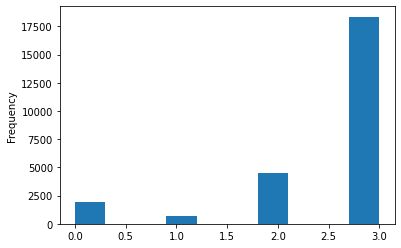

In [15]:
test['labels'].plot.hist()

In [16]:
len(test[test['labels']==0]), len(test[test['labels']==1]), len(test[test['labels']==2]), len(test[test['labels']==3])

(1903, 697, 4464, 18349)

In [17]:
model = ClassificationModel(config['model']['model_type'],
                            config['model']['model_name'],
                            num_labels=len(l2e),
                            weight=config['weights'],
                            args=config['training'])

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [18]:
model.train_model(train)

  0%|          | 0/49972 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/12493 [00:00<?, ?it/s]

(124930, 0.11720105734690019)

## Model Evaluation

In [19]:
def process_model_output(model_outputs: np.ndarray, e2l: dict):
    '''Processes model output and converts to label format
    
    Args:
        model_outputs (np.ndarray): Model output after activation layer
        e2l (dict): encoding mapping to label
    
    Returns:
        list of model predictions as labels
    '''
    prediction = np.argmax(model_outputs, axis=1)
    output = [e2l[p] for p in prediction]
    
    return output

In [20]:
result, model_outputs, wrong_predictions = model.eval_model(test, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/25413 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

In [21]:
result

{'mcc': 0.8571382880603599,
 'acc': 0.9374729469169323,
 'eval_loss': 1.33771602043271}

In [22]:
LABELS = [k for k,_ in l2e.items()]
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

In [23]:
def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

In [24]:
def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))

In [25]:
def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

In [26]:
prediction = process_model_output(model_outputs, e2l)
targets = test['labels'].map(e2l).tolist()

In [27]:
report_score(prediction, targets)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |   1347    |    139    |    329    |    12     |
-------------------------------------------------------------
| disagree  |    52     |    336    |    124    |     4     |
-------------------------------------------------------------
|  discuss  |    462    |    183    |   3875    |    67     |
-------------------------------------------------------------
| unrelated |    42     |    39     |    136    |   18266   |
-------------------------------------------------------------
Score: 10446.75 out of 11550.75	(90.44217907928056%)


90.44217907928056

## Generate Submission

In [28]:
def save_submission(prediction: list):
    '''Helper function to prepare prediction to submission format.'''
    
    submission_df = read_data(path, 'test')
    submission_df = submission_df[['Headline', 'Body ID']]
    submission_df['Stance'] = prediction
    
    submission_df.to_csv('answer.csv', index=False, encoding='utf-8')

In [29]:
save_submission(prediction)